In [4]:
%matplotlib inline
import numpy as np


In [18]:
import numpy as np

def metropolis(e1, e2, t):
    """
    Evaluate metropolis condition with:
    
      e1 :  Energy function for current state
      e2 :  Energy function for proposed state
      t  :  temperature
      
    Always swap if new state is better.  Take disadvantageous swap with probability
    p = exp(-(e2-e1)/t).  For simulated annealing, t gets smaller with higher iterations.
    """
    if e2 < e1:
        return True
    
    x = (e2-e1)/t
    
    if np.random.rand() < np.exp(-x):
        return True
    return False


def simulated_annealing(x0, energy_fun, perm_fun, 
                        accept_reject_update_fun=None,
                        steps=10000, t0=1.0, tau=100,
                        report_steps=100,
                        report=False):
    x = x0.copy()
    e = np.zeros(shape=(steps,))
    swaps = list()
    for t in np.arange(0, steps):
        x_cand = x.copy()
        perm_fun(x_cand)
        e1 = energy_fun(x)
        e2 = energy_fun(x_cand)
        temp = np.exp(-t/tau)
        accept = metropolis(e1, e2, temp)
        if accept:
            x = x_cand
            e[t] = e2
        else:
            e[t] = e1
        swaps.append(accept)
        if accept_reject_update_fun is not None:
            accept_reject_update_fun(accept)
            
        if report and t % report_steps == 0:
            print('[{0}] Energy = {1}, T={2}'.format(t, e[t], temp))
        
    return x, e, swaps


def permute_two(mat, i1, i2):
    """
    Re-order matrix by swapping two rows / columns
    """
    if i1 == i2:
        return
    
    # Row exchange
    row1 = np.array(mat[i1, :])
    row2 = np.array(mat[i2, :])
    mat[i1, :] = row2
    mat[i2, :] = row1
    
    # Column exchange
    col1 = np.array(mat[:, i1])
    col2 = np.array(mat[:, i2])
    mat[:, i1] = col2
    mat[:, i2] = col1
    

def random_permute_two(mat):
    i1 = np.random.randint(0, mat.shape[0])
    i2 = np.random.randint(0, mat.shape[0])
    permute_two(mat, i1, i2)
    return i1, i2
 
    
def random_permutation_matrix(n):
    indices = np.arange(0,n)
    shuffled = np.random.permutation(indices)
    
    mat = np.zeros(shape=(n,n))
    
    for i in indices:
        j = shuffled[i]
        mat[i,j] = 1
    
    return shuffled, mat


class ReorderPermuter:
    """
    This is just a wrapper class for the random row/column swap function that does additional 
    book-keeping on the index array.  After the algorithm is complete, the index array will have been
    re-ordered to provide lookup of labels associated with the matrix or to generate the permutation
    matrix solved for by simulated annealing.
    """
    
    def __init__(self, original_mat, indices=None, n=None):
        if indices is None:
            if n is None:
                raise Exception('Must supply either array of indices or value of n (matrix dimension)')
            indices = np.arange(0, n)
            n = indices.shape[0]
        self.n = n
        self.indices = indices
        self.original_mat = original_mat.copy()
        
    def random_row_column_reorder(self, mat):
        i1, i2 = random_permute_two(mat)
        # swap indices
        self._candidate_indices = (i1,i2)
        
    def update_indices(self, accept):
        if accept:
            i1 = self._candidate_indices[0]
            i2 = self._candidate_indices[1]
            tmp = self.indices[i2]
            self.indices[i2] = self.indices[i1]
            self.indices[i1] = tmp
        
    def get_permutation_matrix(self):
        
        permutation_mat = np.zeros(shape=(self.n, self.n))
        for i in np.arange(0, self.n):
            permutation_mat[i, self.indices[i]] = 1.0
        return permutation_mat
            
    def reorder_with_permutation(self, mat=None):
        
        if mat is None:
            mat = self.original_mat
        
        pmat = self.get_permutation_matrix()
        # Row / column reorder with permutation matrix
        return np.matmul(pmat.transpose(), np.matmul(mat, pmat))
    
    def reorder_permutation_inverse(self, mat=None):
        
        if mat is None:
            mat = self.original_mat
            
        pmat = self.get_permutation_matrix()
        return np.matmul(pmat, np.matmul(mat, pmat.transpose()))


def rbf_cov(n, length_scale=None):
    """
    Simple rbf kernel covariance with "distance" uniformly tied to
    index in the matrix (creates band-diagonal matrix for testing)
    """
    if length_scale is None:
        length_scale = n/4
    scale = np.power(length_scale, 2)
    cov = np.zeros(shape=(n, n))
    for i in np.arange(0, n):
        for j in np.arange(0, n):
            d = np.power(i-j, 2) / scale
            cov[i,j] = np.exp(-d)
    return cov


def matrix_score(m):
    """
    Objective function to penalize off-diagonal matrix mass.  Yields 
    zero for a diagonal matrix.  Minimization of this function over 
    row/column ordering minimizes matrix bandwidth (akin to banded 
    """
    score = 0
    m_abs = np.abs(m)
    norm = np.power(m.shape[0], 4) / 2
    for i in np.arange(0, m.shape[0]):
        for j in np.arange(0, m.shape[1]):
            score += m_abs[i,j]*(i-j)*(i-j)
            
    return score / norm

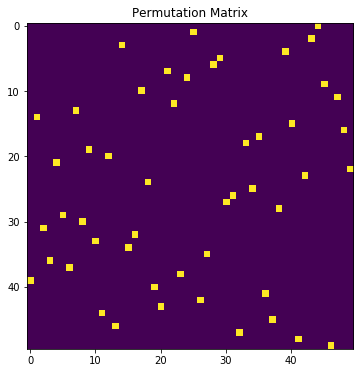

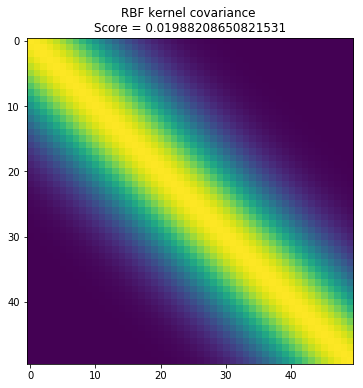

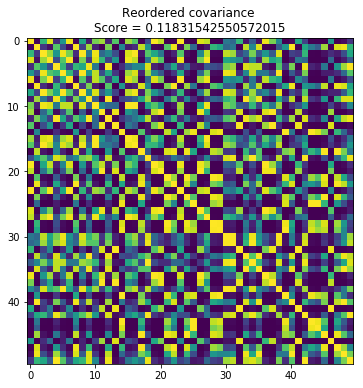

In [19]:
n = 50
figsize=(6,6)

# initial covariance
cov = rbf_cov(n)
indices, perm = random_permutation_matrix(n)
cov_reorder = np.matmul(np.transpose(perm), np.matmul(cov, perm))

plt.figure(figsize=figsize)
plt.imshow(perm)
plt.title('Permutation Matrix')
plt.show()

plt.figure(figsize=figsize)
plt.title('RBF kernel covariance \nScore = {0}'.format(matrix_score(cov)))
plt.imshow(cov)
plt.show()

plt.figure(figsize=figsize)
plt.title('Reordered covariance \nScore = {0}'.format(matrix_score(cov_reorder)))
plt.imshow(cov_reorder)
plt.show()



In [20]:
permuter = ReorderPermuter(n=n, original_mat=cov_reorder)


mat, e, swap = simulated_annealing(x0=cov_reorder, 
                                   energy_fun=matrix_score, 
                                   perm_fun=permuter.random_row_column_reorder,
                                   accept_reject_update_fun=permuter.update_indices,
                                   steps=10000, report=True)

[0] Energy = 0.12118133264234436, T=1.0
[100] Energy = 0.1227425270756285, T=0.36787944117144233
[200] Energy = 0.12521054365156412, T=0.1353352832366127
[300] Energy = 0.12315018753535176, T=0.049787068367863944
[400] Energy = 0.12044332636118944, T=0.01831563888873418
[500] Energy = 0.1111631523651591, T=0.006737946999085467
[600] Energy = 0.10574372879857968, T=0.0024787521766663585
[700] Energy = 0.10262977843920318, T=0.0009118819655545162
[800] Energy = 0.06573467383766482, T=0.00033546262790251185
[900] Energy = 0.051764507494411346, T=0.00012340980408667956
[1000] Energy = 0.041670078881622066, T=4.5399929762484854e-05
[1100] Energy = 0.036089393489844246, T=1.670170079024566e-05
[1200] Energy = 0.031452008622724584, T=6.14421235332821e-06
[1300] Energy = 0.02891901944595569, T=2.2603294069810542e-06
[1400] Energy = 0.025309731663600146, T=8.315287191035679e-07
[1500] Energy = 0.024080001184474818, T=3.059023205018258e-07
[1600] Energy = 0.02268468815193584, T=1.125351747192591

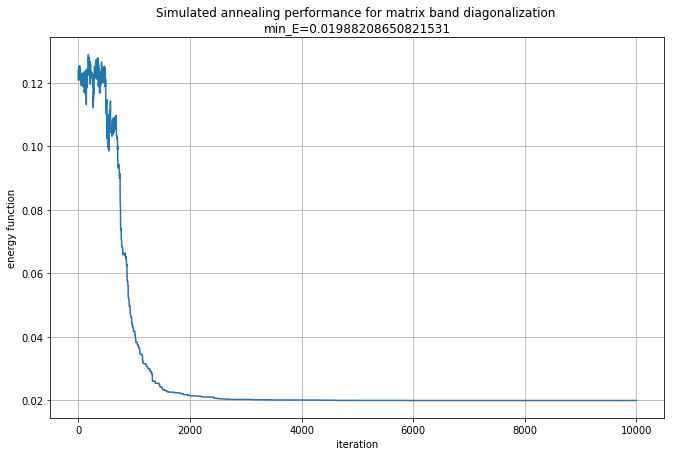

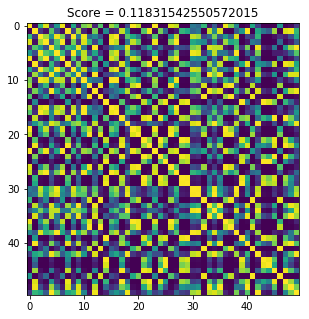

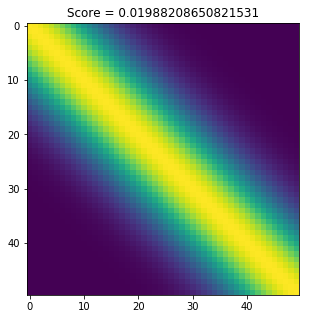

In [22]:
plt.figure(figsize=(11,7))
plt.plot(e)
plt.xlabel('iteration')
plt.ylabel('energy function')
plt.title('Simulated annealing performance for matrix band diagonalization \n'
          + 'min_E={0}'.format(np.min(e)))

plt.grid(True)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov_reorder)))
plt.imshow(cov_reorder)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(mat)))
plt.imshow(mat)
plt.show()

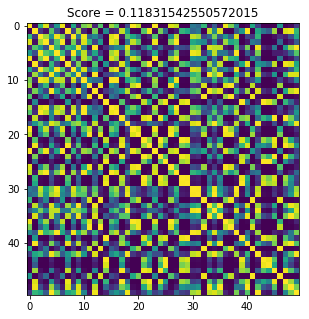

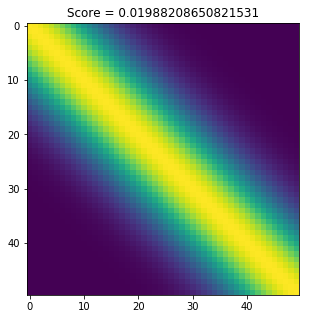

In [24]:
# Test effective permutation inverse
transform_mat = permuter.reorder_permutation_inverse()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(permuter.original_mat)))
plt.imshow(permuter.original_mat)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(transform_mat)))
plt.imshow(transform_mat)
plt.show()

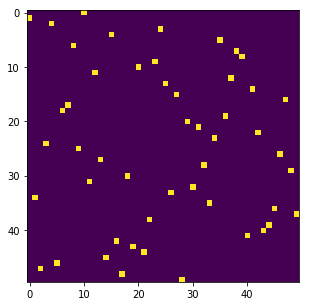

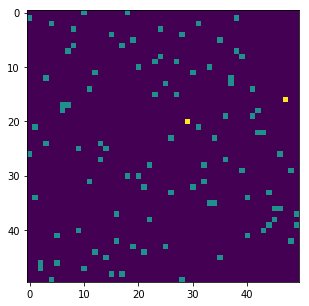

[10  0  4 24 15 35  8 38 39 23 20 12 37 25 41 27 47  7  6 36 29 31 42 34
  3  9 46 13 32 48 18 11 30 26  1 33 45 49 22 44 43 40 16 19 21 14  5  2
 17 28]
[26 21 46 12 49 41 17  7  3 40 47 14 44 24 25 48 37  6  0  5 30 32 28 15
  8 43 23  9  4 20 11  2 31 10 35 45 27 13  1 29 34 19 18 22 33 38 36 16
 42 39]


In [32]:
plt.figure(figsize=(5,5))
plt.imshow(perm)
plt.show()

solved_perm_mat = permuter.get_permutation_matrix()

plt.figure(figsize=(5,5))
plt.imshow(solved_perm_mat.transpose()+perm)
plt.show()

print(indices)
print(permuter.indices)

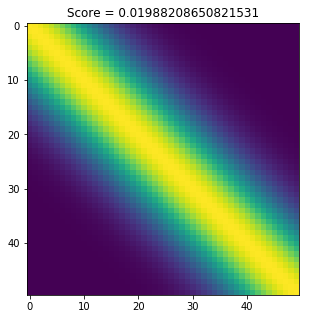

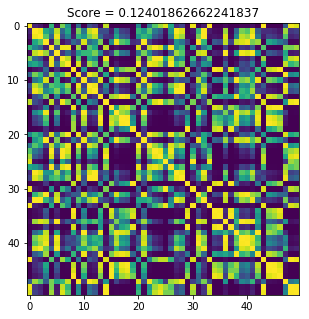

In [33]:
#permutation by random swaps

cov_copy = cov.copy()

for i in np.arange(0,n*10):
    i1 = np.random.randint(0,n)
    i2 = np.random.randint(0,n)
    permute_two(cov_copy, i1, i2)
    
plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov)))
plt.imshow(cov)
plt.show()

plt.figure(figsize=(5,5))
plt.title('Score = {0}'.format(matrix_score(cov_copy)))
plt.imshow(cov_copy)
plt.show()
